In [1]:
# Import libraries 

import pandas as pd 
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm #i like statsmodels result table, lets me explore the coefficents more.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lazypredict.Supervised import LazyClassifier

from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.feature_selection import SelectFromModel
from yellowbrick.model_selection import RFECV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

C:\Users\abebu\DS\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
#load dataset 
td = pd.read_csv('term-deposit-marketing-2020.csv', header = 0)
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
age          40000 non-null int64
job          40000 non-null object
marital      40000 non-null object
education    40000 non-null object
default      40000 non-null object
balance      40000 non-null int64
housing      40000 non-null object
loan         40000 non-null object
contact      40000 non-null object
day          40000 non-null int64
month        40000 non-null object
duration     40000 non-null int64
campaign     40000 non-null int64
y            40000 non-null object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [3]:
# lets see if there are any null values 
td.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Fortunatlly there are no missing values. 

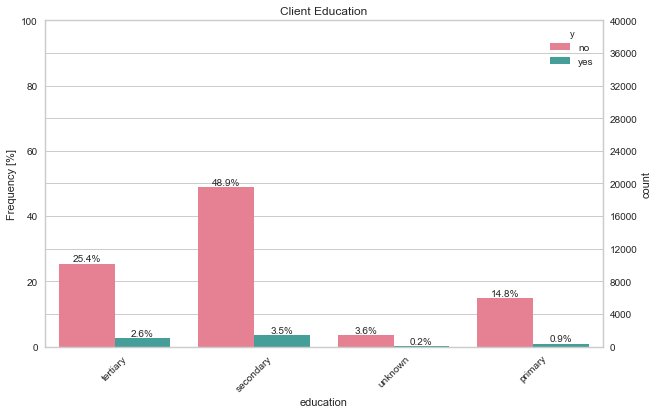

In [4]:
# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.countplot(data = td, x = 'education', palette='husl', hue='y')
ncount = len(td)
ax2 = ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Frequency [%]')
ax.set_ylabel('count')

ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha = 'center', va = 'bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)
ax.set_title('Client Education')

# And use a MultipleLocator to ensure a tick spacing of 20
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)


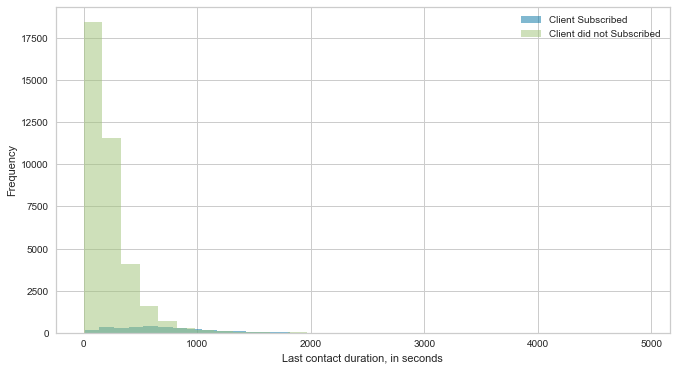

In [5]:
# check if there is any trend with last contact duration
subscribed = td.duration.loc[td.y == 'yes']
not_subscribed = td.duration.loc[td.y == 'no']

plt.figure(figsize = (11, 6))
_ = plt.hist(subscribed, bins = 30, alpha = 0.5, label='Client Subscribed')
_ = plt.hist(not_subscribed, bins=30, alpha=0.5, label='Client did not Subscribed')
_ = plt.xlabel('Last contact duration, in seconds')
_ = plt.ylabel('Frequency')
_ = plt.legend()


In [6]:
'''Since the label of the data-set are given in terms of ‘yes’ and ‘no’, it’s necessary to replace them with numbers,
possibly with 1 and 0 respectively, so that they can be used in modelling of the data. In the first step we will convert 
the output labels of the data-set from binary strings of yes/no to integers 1/0.'''

td['y'] = (td['y'] == 'yes').astype(int)  # changing yes to 1 and no to 0
td['default'] = (td['default'] == 'yes').astype(int)  # changing yes to 1 and no to 0
td['loan'] = (td['loan'] == 'yes').astype(int)  # changing yes to 1 and no to 0
td['housing'] = (td['housing'] == 'yes').astype(int)  # changing yes to 1 and no to 0

td

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,0,395,0,0,cellular,3,jun,107,1,0
39996,30,management,single,tertiary,0,3340,0,0,cellular,3,jun,238,3,1
39997,54,admin,divorced,secondary,0,200,0,0,cellular,3,jun,170,1,1
39998,34,management,married,tertiary,0,1047,0,0,cellular,3,jun,342,1,0


In [7]:
# lets change all the features to binary class using get_dummies
td = pd.get_dummies (td, columns = ['marital', 'education', 'contact', 'month','job'])
td

,age,default,balance,housing,loan,day,duration,campaign,y,marital_divorced,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,0,2143,1,0,5,261,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,44,0,29,1,0,5,151,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,76,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,5,92,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,5,198,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,395,0,0,3,107,1,0,0,...,0,0,0,0,0,0,0,1,0,0
39996,30,0,3340,0,0,3,238,3,1,0,...,0,0,1,0,0,0,0,0,0,0
39997,54,0,200,0,0,3,170,1,1,1,...,0,0,0,0,0,0,0,0,0,0
39998,34,0,1047,0,0,3,342,1,0,0,...,0,0,1,0,0,0,0,0,0,0


This graph shows, there is an outlier with the duration data. I will need to check using box plot. 

In [8]:
# First implement simple model 

# Create arrays for features and target variable
y = td['y'].values
x = td.drop(['y'], axis=1)


# Print the dimensions of X and y 
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(x.shape))

Dimensions of y before reshaping: (40000,)
Dimensions of X before reshaping: (40000, 41)


In [9]:
print (y)

[0 0 0 ... 1 0 0]


In [10]:
x = pd.DataFrame(x)
x

,age,default,balance,housing,loan,day,duration,campaign,marital_divorced,marital_married,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,0,2143,1,0,5,261,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,44,0,29,1,0,5,151,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,76,1,0,1,...,1,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,5,92,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,5,198,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,395,0,0,3,107,1,0,1,...,0,0,0,0,0,0,0,1,0,0
39996,30,0,3340,0,0,3,238,3,0,0,...,0,0,1,0,0,0,0,0,0,0
39997,54,0,200,0,0,3,170,1,1,0,...,0,0,0,0,0,0,0,0,0,0
39998,34,0,1047,0,0,3,342,1,0,1,...,0,0,1,0,0,0,0,0,0,0


In [11]:
# Split the data into a training and test set.
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 5, test_size = 0.2)

clf = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf.fit(x_train, y_train)

# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(clf.predict(x_train), y_train))))
print('Testing Accuracy: {}'.format((accuracy_score(clf.predict(x_test), y_test))))

Training Accuracy: 0.93325
Testing Accuracy: 0.928625


In [12]:
x_train.shape

(32000, 41)

In [13]:
y_train.shape

(32000,)

In [14]:
td['y'].value_counts()

0    37104
1     2896
Name: y, dtype: int64

In [15]:
# Generate the confusion matrix and classification report

ypred = clf.predict(x_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[7291   83]
 [ 488  138]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7374
           1       0.62      0.22      0.33       626

    accuracy                           0.93      8000
   macro avg       0.78      0.60      0.64      8000
weighted avg       0.91      0.93      0.91      8000



In [16]:
# First lets try how the model performs if we can randomly undersmaple the Class 0, to blance the data. 

rus = RandomUnderSampler(sampling_strategy = 'majority')
x_res, y_res = rus.fit_resample (x, y)
# summarize class distribution

print(Counter(y_res))

Counter({0: 2896, 1: 2896})


In [17]:
# Split the data into a training and test set.
x_res_train, x_res_test, y_res_train, y_res_test = train_test_split(x_res, y_res, random_state = 5, test_size = 0.2)

# Fit the model on the trainng data.
clf.fit(x_res_train, y_res_train)
y_res_pred = clf.predict(x_res_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_res_test, y_res_pred))
print(classification_report(y_res_test, y_res_pred))

[[488  92]
 [113 466]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       580
           1       0.84      0.80      0.82       579

    accuracy                           0.82      1159
   macro avg       0.82      0.82      0.82      1159
weighted avg       0.82      0.82      0.82      1159



In [18]:
x_res_train.shape

(4633, 41)

In [19]:
from imblearn.over_sampling import RandomOverSampler
# lets try how the model performs if we can randomly oversmaple the Class 1, to blance the data. 

ros = RandomOverSampler(sampling_strategy = 'minority')
x_ros, y_ros = ros.fit_resample (x, y)
# summarize class distribution

print(Counter(y_ros)) 


Counter({0: 37104, 1: 37104})


In [20]:
# Split the data into a training and test set.
x_ros_train, x_ros_test, y_ros_train, y_ros_test = train_test_split(x_ros, y_ros,random_state = 5, test_size = 0.2)

# Fit the model on the trainng data.
clf.fit(x_ros_train, y_ros_train)
y_ros_pred = clf.predict(x_ros_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_ros_test, y_ros_pred))
print(classification_report(y_ros_test, y_ros_pred))

[[6303 1173]
 [1494 5872]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      7476
           1       0.83      0.80      0.81      7366

    accuracy                           0.82     14842
   macro avg       0.82      0.82      0.82     14842
weighted avg       0.82      0.82      0.82     14842



In [21]:
y_res_train.shape

(4633,)

### Feature Engineering 
Use tree-based algorithm to see what particular features would add value to solve the problems (feature importance and coefficients). How does Random forest select features?
Random forests consist of 4 –12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived from how “pure” each of the buckets is.

In [22]:
# feature enginering 

fselect_res = SelectFromModel (RandomForestClassifier(n_estimators = 1000)) # model fitting and feature selection in one line code
fselect_res.fit(x_res_train, y_res_train) # in feature selection procedures, its a good practice to select the features by examining only the training set to avoid overfitting. 

# To see which features are important we can sue get_support method on the fitted model

fselect_res.get_support()





array([ True, False,  True, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [23]:
fselect_res.get_support(indices = True)

array([0, 2, 5, 6, 7], dtype=int64)

In [24]:
scol = td.iloc[0:1, [0,2,5,6,7]] 
scol

,age,balance,day,duration,campaign
0,58,2143,5,261,1


In [25]:
col_list = list(scol)
col_list

['age', 'balance', 'day', 'duration', 'campaign']

In [26]:
# Make a list and count the selected features

x_res_train = pd.DataFrame(x_res_train)
selected_f = x_res_train.columns[(fselect_res.get_support())]
len(selected_f)



5

In [27]:
# Threshold used 

fselect_res.threshold_

0.024390243902439022

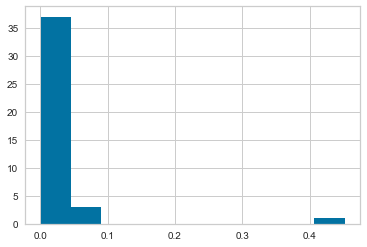

In [28]:
# plot distribution of feature importance 

pd.Series(fselect_res.estimator_.feature_importances_.ravel()).hist()

In [29]:
x_res_train.shape

(4633, 41)

In [30]:
# model.transform (data) reduce the data to the selected features

x_res_train_sel = fselect_res.transform(x_res_train)
x_res_train_sel.shape


(4633, 5)

In [31]:
x_res_test.shape

(1159, 41)

In [32]:
x_res_test_sel = fselect_res.transform(x_res_test)
x_res_test_sel.shape

(1159, 5)

In [43]:
# Fit logistic regression using only selected features 

clf_s = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf_s.fit(x_res_train_sel, y_res_train)

# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(clf_s.predict(x_res_train_sel), y_res_train))))
print('Testing Accuracy: {}'.format((accuracy_score(clf_s.predict(x_res_test_sel), y_res_test))))

Training Accuracy: 0.7975393913231168
Testing Accuracy: 0.7894736842105263


In [44]:
y_pred_sel = clf_s.predict(x_res_test_sel)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_res_test, y_pred_sel))
print(classification_report(y_res_test, y_pred_sel))

[[498  82]
 [162 417]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       580
           1       0.84      0.72      0.77       579

    accuracy                           0.79      1159
   macro avg       0.80      0.79      0.79      1159
weighted avg       0.80      0.79      0.79      1159



In [45]:
# Fit Random Forest Classifier using selected features and undersampled data
rfc = (RandomForestClassifier(n_estimators = 1000))
rfc.fit(x_res_train_sel, y_res_train)

y_pred_sel = rfc.predict(x_res_test_sel)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_res_test, y_pred_sel))
print(classification_report(y_res_test, y_pred_sel))


[[481  99]
 [118 461]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       580
           1       0.82      0.80      0.81       579

    accuracy                           0.81      1159
   macro avg       0.81      0.81      0.81      1159
weighted avg       0.81      0.81      0.81      1159



In [46]:
from lazypredict.Supervised import LazyClassifier

#Explore which models would work well with this dataset. `lazyPredict` helps generate sutable models. 
clf = LazyClassifier(verbose = 0, ignore_warnings = True, predictions = True, custom_metric = None)
models,predictions = clf.fit(x_res_train_sel, x_res_test_sel, y_res_train, y_res_test)

print(models)

100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.82               0.82     0.82      0.82   
LGBMClassifier                     0.81               0.81     0.81      0.81   
AdaBoostClassifier                 0.81               0.81     0.81      0.81   
ExtraTreesClassifier               0.81               0.81     0.81      0.81   
SVC                                0.80               0.80     0.80      0.80   
RandomForestClassifier             0.80               0.80     0.80      0.80   
NuSVC                              0.79               0.79     0.79      0.79   
SGDClassifier                      0.79               0.79     0.79      0.79   
LogisticRegression                 0.79               0.79     0.79      0.79   
CalibratedClassifierCV             0.79               0.79     0.79      0.79   
LinearSVC                   

In [47]:
# Based on the above lazypredict results, XGBoost algorithm. 
model = XGBClassifier()
eval_set = [(x_res_train_sel, y_res_train ), (x_res_test_sel, y_res_test)]
eval_metric = ["auc","error"]
%time model.fit(x_res_train_sel, y_res_train, eval_metric = eval_metric, eval_set = eval_set, verbose = True)


[0]	validation_0-auc:0.865975	validation_0-error:0.19836	validation_1-auc:0.841924	validation_1-error:0.220017
[1]	validation_0-auc:0.874145	validation_0-error:0.189078	validation_1-auc:0.849331	validation_1-error:0.218292
[2]	validation_0-auc:0.87895	validation_0-error:0.192964	validation_1-auc:0.852746	validation_1-error:0.212252
[3]	validation_0-auc:0.883265	validation_0-error:0.190805	validation_1-auc:0.856521	validation_1-error:0.213115
[4]	validation_0-auc:0.883623	validation_0-error:0.191021	validation_1-auc:0.856234	validation_1-error:0.213115
[5]	validation_0-auc:0.885809	validation_0-error:0.193395	validation_1-auc:0.858823	validation_1-error:0.213115
[6]	validation_0-auc:0.885758	validation_0-error:0.187567	validation_1-auc:0.856693	validation_1-error:0.213115
[7]	validation_0-auc:0.887091	validation_0-error:0.18951	validation_1-auc:0.859463	validation_1-error:0.213978
[8]	validation_0-auc:0.88913	validation_0-error:0.192532	validation_1-auc:0.861872	validation_1-error:0.215

XGBClassifier()

In [48]:
# Time to fine-tune our model 

xgbc = XGBClassifier(silent = False, 
                      scale_pos_weight = 1,
                      learning_rate = 0.01,  
                      colsample_bytree = 0.8, # % of columns used by each tree. We already feature engenered the colunmns hence will use all. 
                      subsample = 0.8, # % of rows taken to build the tree
                      objective = 'binary:logistic', 
                      n_estimators = 1000, # 100 if size of data is high, 1000 if its medium-low 
                      max_depth = 5, # start from low number (3) and will increase it incrementally by 1, until no performance gain. 
                      alpha = 0.3,
                      gamma = 5)  # acts as a regularization


xgbc.fit(x_res_train_sel, y_res_train)
preds = xgbc.predict(x_res_test_sel)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_res_test, preds))
print(classification_report(y_res_test, preds))


[[494  86]
 [121 458]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       580
           1       0.84      0.79      0.82       579

    accuracy                           0.82      1159
   macro avg       0.82      0.82      0.82      1159
weighted avg       0.82      0.82      0.82      1159



In [49]:
# Evaluate XGBoost model with k-fold Cross Validation

kfold = KFold(n_splits = 5, random_state = 7)
model = xgbc
cv_results = cross_val_score(model, x_res_train_sel, y_res_train, cv = kfold)
print ('Accuraccy: %.2f%% (%.2f%%)' % (cv_results.mean()*100, cv_results.std()*100))


Accuraccy: 81.78% (1.02%)


In [50]:

# Convert the datset into an optimized data stracture called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 
data_dmatrix = xgb.DMatrix(data = x_res_train_sel, label = y_res_train)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate" : 0.01, "colsample_bytree": 1, 
          "subsample": 0.8, "n_estimators" : 1000, "alpha": 0.3, "gamma": 5}

# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain = data_dmatrix, params = params,
                   nfold = 5, num_boost_round = 5,
                   metrics = "auc", as_pandas = True, seed = 123)
# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])



   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0            0.86           0.00           0.86          0.01
1            0.87           0.00           0.86          0.01
2            0.87           0.00           0.87          0.01
3            0.88           0.00           0.87          0.01
4            0.88           0.00           0.87          0.01
0.8688916000000001


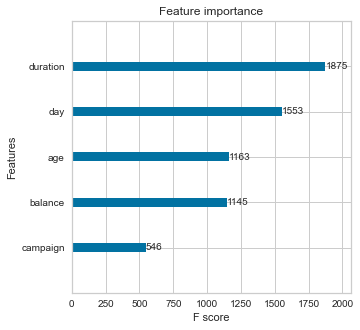

In [51]:
x_res_train_sel = pd.DataFrame(x_res_train_sel)
x_res_test_sel = pd.DataFrame(x_res_test_sel)

x_res_train_sel.columns = ['age', 'balance', 'day', 'duration', 'campaign']
x_res_test_sel.columns = ['age', 'balance', 'day', 'duration', 'campaign']

xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [52]:
# Above we have see there are multiple classifiers that have similar perfomrmance. In such cases its advised to employ Voting Classifier - evaluates multiple classifiers to make predictions.

from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

# First select the models to include in the voting classifier

lgbmc = LGBMClassifier()
xgbc = XGBClassifier()
rfc = RandomForestClassifier()
svc = SVC()
knnc = KNeighborsClassifier()

# create object for voting classifier. 
vc = VotingClassifier(estimators = [('lgbm', lgbmc), ('xgb', xgbc), ('rf', rfc), ('svc', svc), ('knn', knnc)], 
                      voting = 'hard') # voting parameter: soft for even number classifiers (weighted apporach), hard for odd number of classifiers (majority carry the vote)

# fit the voting classifier on the data 
vc.fit(x_res_train_sel, y_res_train)

# make predictions 
vc_pred = vc.predict(x_res_test_sel)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_res_test, vc_pred))
print(classification_report(y_res_test, vc_pred))

[[494  86]
 [128 451]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       580
           1       0.84      0.78      0.81       579

    accuracy                           0.82      1159
   macro avg       0.82      0.82      0.82      1159
weighted avg       0.82      0.82      0.82      1159

